# 🧠 TP - Fuzzy C-Means (FCM)
## Segmentation d’image floue

**Objectif du TP :**
- Implémenter l’algorithme *Fuzzy C-Means* (FCM)
- L’appliquer à la segmentation d’une image (par intensité)
- Visualiser le résultat sous forme de heatmap + segmentation binaire

---


In [11]:
!pip -q install numpy matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float

## 🔍 1. Chargement et préparation de l’image
On utilise une image locale (upload) ou depuis une URL.

- Si l’image est en couleur (RGB), on la convertit en niveaux de gris.  
- On la convertit aussi en flottants dans [0,1] pour éviter les erreurs numériques.
- Enfin, on la **vectorise** sous forme de matrice `X` de taille `(N,1)` :
  - N = nombre de pixels  
  - Chaque pixel correspond à une valeur d’intensité.


Saving milky-way.jpg to milky-way.jpg


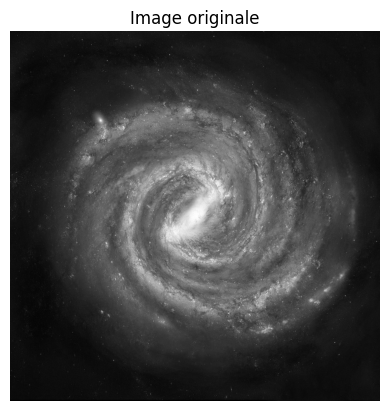

Forme de X : (1048576, 1)


In [12]:
from google.colab import files
uploaded = files.upload()

path = list(uploaded.keys())[0]
img = io.imread(path)

I = img_as_float(color.rgb2gray(img)) if img.ndim == 3 else img_as_float(img)
X = I.reshape(-1, 1)

plt.imshow(I, cmap='gray')
plt.title("Image originale")
plt.axis('off')
plt.show()

print("Forme de X :", X.shape)


## ⚙️ 2. Initialisation de la matrice d’appartenance `U`

Chaque pixel i a un degré d’appartenance à chaque cluster j :
- `U[i,j]` ∈ [0,1]
- Chaque ligne de `U` doit **sommmer à 1**

On crée donc `U` aléatoirement, puis on normalise **ligne par ligne** :
```python
U = np.random.rand(N, C)
U = U / U.sum(axis=1, keepdims=True)


In [13]:

N = X.shape[0]
C = 2
U = np.random.rand(N, C)
U = U / U.sum(axis=1, keepdims=True)

print("Forme de U :", U.shape)
print("Somme de la première ligne =", U[0].sum())


Forme de U : (1048576, 2)
Somme de la première ligne = 1.0


In [14]:
import numpy as np

def fcm(X, C=2, m=2.0, eps=1e-4, max_iter=200):
    """
    Implémentation simple de l'algorithme Fuzzy C-Means.
    X : données (pixels vectorisés) → taille (N, d)
    C : nombre de clusters
    m : coefficient de flou (>1)
    eps : critère d'arrêt
    max_iter : nombre max d'itérations
    """
    N = X.shape[0]
    U = np.random.rand(N, C)
    U = U / U.sum(axis=1, keepdims=True)

    for it in range(max_iter):
        U_old = U.copy()

        um = U ** m
        den = um.sum(axis=0).reshape(C, 1)
        den[den == 0] = 1e-12
        centers = (um.T @ X) / den

        dist = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2) + 1e-12

        power = 2.0 / (m - 1.0)
        denom = (dist[:, :, None] / dist[:, None, :]) ** power
        U = 1.0 / denom.sum(axis=2)

        if np.linalg.norm(U - U_old) < eps:
            print(f"✅ Convergence atteinte en {it+1} itérations.")
            break

    return centers, U


## 🧮 3. Calcul des centres des clusters

Formule :
\[
c_j = \frac{\sum_i (u_{ij})^m x_i}{\sum_i (u_{ij})^m}
\]

- On élève `U` à la puissance `m` (souvent `m=2`) pour accentuer les fortes appartenances.  
- On fait une **moyenne pondérée** des pixels selon leurs degrés flous.


In [15]:
def update_centers(X, U, m):
    um = U ** m
    num = (um.T @ X)
    den = um.sum(axis=0).reshape(-1, 1)
    den[den == 0] = 1e-12
    centers = num / den
    return centers

m = 2.0
centers = update_centers(X, U, m)
print("Centres initiaux :", centers.ravel())


Centres initiaux : [0.22320493 0.22325219]


## 🚀 5. Exécution complète + visualisation
On applique FCM sur l’image avec `C=2` et `m=2.0`.

- `U[:,0]` = appartenance au cluster 1 (affichée en heatmap)
- `argmax(U)` = segmentation “durcie” (chaque pixel → cluster dominant)


✅ Convergence atteinte en 88 itérations.


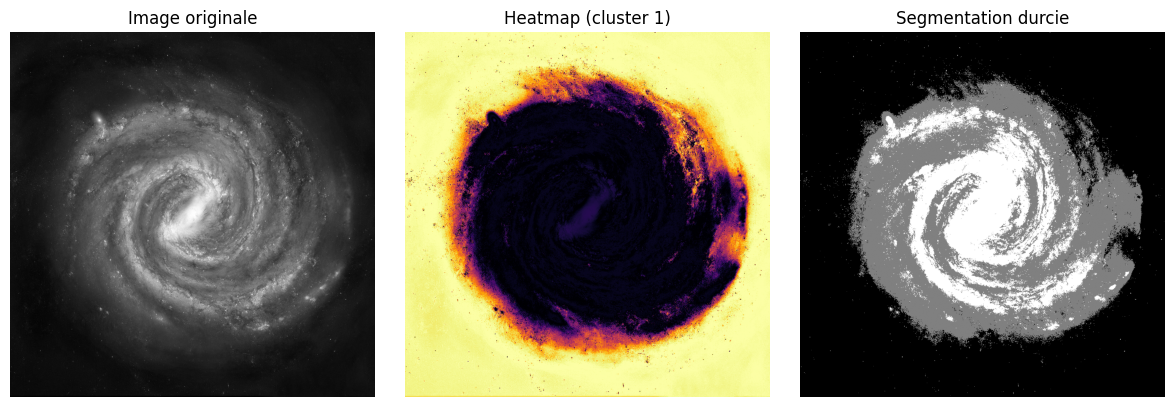

In [17]:
centers, U = fcm(X, C=3, m=2.0)

U1 = U[:, 0].reshape(I.shape)
seg = np.argmax(U, axis=1).reshape(I.shape)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(I, cmap='gray'); ax[0].set_title("Image originale"); ax[0].axis('off')
ax[1].imshow(U1, cmap='inferno'); ax[1].set_title("Heatmap (cluster 1)"); ax[1].axis('off')
ax[2].imshow(seg, cmap='gray'); ax[2].set_title("Segmentation durcie"); ax[2].axis('off')
plt.tight_layout(); plt.show()
